knn imputation for age

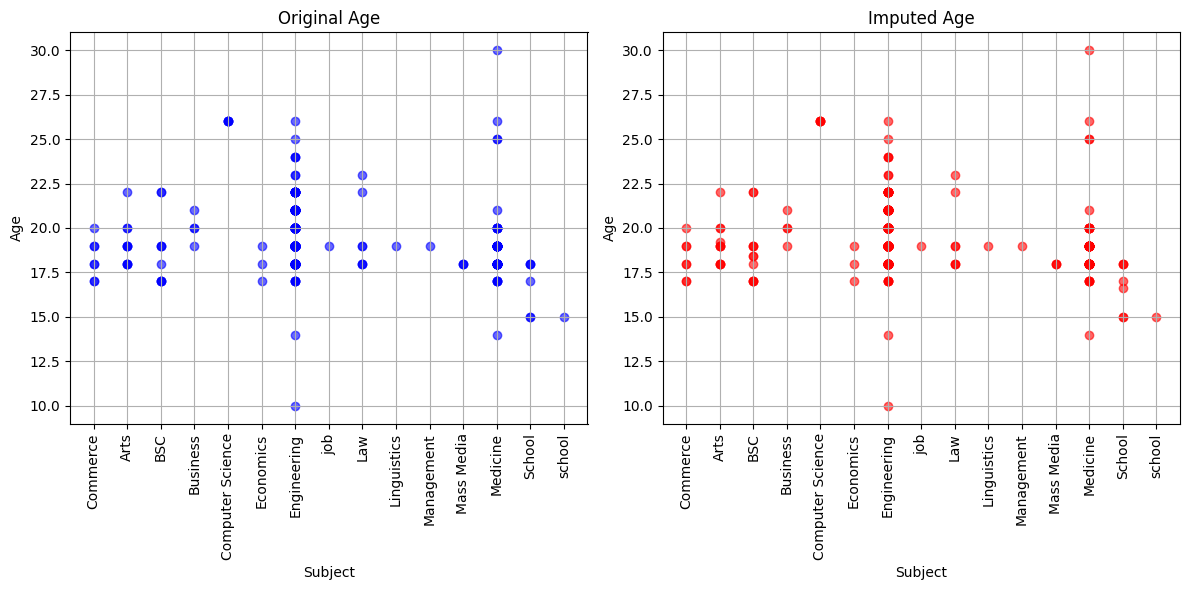

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Load the Excel file
df = pd.read_excel('raw data-2.xlsx')

# Step 1: Strip spaces in 'Subject'
df['Subject'] = df['Subject'].astype(str).str.strip()

# Save original for comparison
df_original = df.copy()

# Step 2: KNN Imputation using 'Age' and encoded 'Subject'
le = LabelEncoder()
df['Subject_encoded'] = le.fit_transform(df['Subject'])

impute_df = df[['Age', 'Subject_encoded']]
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(impute_df)

# Save imputed Age
df['Imputed_Age'] = imputed[:, 0]

# Step 3: Plotting before vs after
plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 2, 1)
plt.scatter(df['Subject'], df_original['Age'], alpha=0.6, color='blue')
plt.title("Original Age")
plt.xlabel("Subject")
plt.ylabel("Age")
plt.xticks(rotation=90)
plt.grid(True)

# Imputed
plt.subplot(1, 2, 2)
plt.scatter(df['Subject'], df['Imputed_Age'], alpha=0.6, color='red')
plt.title("Imputed Age")
plt.xlabel("Subject")
plt.ylabel("Age")
plt.xticks(rotation=90)
plt.grid(True)

plt.tight_layout()
plt.show()


performance score prediction


✅ Model, Scaler, and Score Range saved successfully.


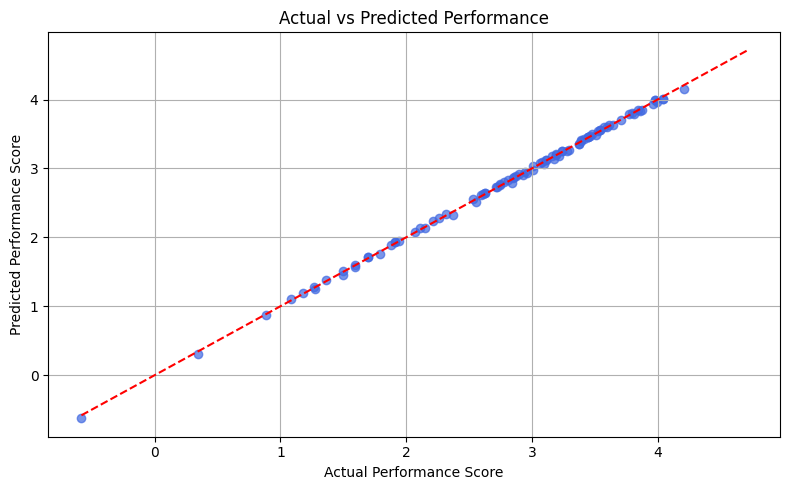

📊 Root Mean Squared Error (RMSE): 0.0225
📈 R-squared (R2): 0.9994


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load data
df = pd.read_excel("raw data-2.xlsx")

# Encode teacher support and peer influence
df['Teacher_Support'] = df['Teacher_Support'].map({'Low': 1, 'Medium': 2, 'High': 3}).fillna(2)
df['Peer_Influence'] = df['Peer_Influence'].map({'Negative': 1, 'Neutral': 2, 'Positive': 3}).fillna(2)

# Feature engineering
scaler_marks = MinMaxScaler()
df['Marks_Score'] = scaler_marks.fit_transform(df[['Marks']])

df['Attendance_Score'] = df['Attendance'] / 4
df['Sleep_Score'] = df['Sleep_Hours'] / 3
df['Health_Score'] = df['Physical_Health'] / 5
df['Motivation_Score'] = df['Teacher_Support'].map({1: 0.3, 2: 0.6, 3: 1.0})
df['Stress_Score'] = df['Late_submissions'] / 3

# Final performance score
df['Performance_Score'] = (
    df['Sleep_Score'] +
    df['Health_Score'] +
    df['Marks_Score'] +
    df['Attendance_Score'] +
    df['Motivation_Score'] -
    df['Stress_Score']
)

# Model input features and target
features = [
    'Sleep_Hours', 'Physical_Health', 'Study_Resources', 'Marks',
    'Attendance', 'Late_submissions', 'Consistency',
    'Teacher_Support', 'Peer_Influence'
]

X = df[features]
y = df['Performance_Score']

# Feature scaling
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Save model, scalers, and score range
joblib.dump(model, 'performance_model.pkl')
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump((y.min(), y.max()), 'score_range.pkl')

print("✅ Model, Scaler, and Score Range saved successfully.")

# Predict and evaluate
y_pred = model.predict(X_test)

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, color='royalblue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # ideal line
plt.xlabel('Actual Performance Score')
plt.ylabel('Predicted Performance Score')
plt.title('Actual vs Predicted Performance')
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"📈 R-squared (R2): {r2:.4f}")


test performance


In [ ]:
import joblib
import pandas as pd

# Load model and scalers
model = joblib.load('performance_model.pkl')
scaler_X = joblib.load('scaler_X.pkl')
min_score, max_score = joblib.load('score_range.pkl')


# Function to get user input
def get_user_input():
    try:
        user_data = {
            "Sleep_Hours": float(input("Sleep score 1-3: ")),
            "Physical_Health": float(input("Physical health (1-5): ")),
            "Study_Resources": int(input("Study resources available: 0 for none 3 for abundant (0-3): ")),
            "Marks": float(input("Marks (0-100): ")),
            "Attendance": int(input("Attendance (90 or above : 4, 80-90 : 3, 75-80 : 2, Below 75 : 1): ")),
            "Late_submissions": int(input("Late submissions (0-3): ")),
            "Consistency": int(input("Consistency (1-4): ")),
            "Teacher_Support": int(input("Teacher support (1=Low, 2=Med, 3=High): ")),
            "Peer_Influence": int(input("Peer influence (1=Neg, 2=Neu, 3=Pos): "))
        }
        return user_data
    except ValueError:
        print("Invalid input. Please enter valid numbers.")
        return None

# Function to predict performance score
def make_prediction(user_data):
    user_df = pd.DataFrame([user_data])
    user_df_scaled = scaler_X.transform(user_df)

    raw_score = model.predict(user_df_scaled)[0]
    scaled_score = 10 * (raw_score - min_score) / (max_score - min_score)
    scaled_score = max(0, min(10, scaled_score))  # Clip between 0-10
    return scaled_score

# Suggestions function
def get_suggestions(user_data):
    suggestions = []
    if user_data['Sleep_Hours'] < 2:
        suggestions.append("Increase sleep to 2.5-3 hours → +5% boost")
    if user_data['Physical_Health'] < 3:
        suggestions.append("Improve physical health (target 4/5) → +5%")
    if user_data['Attendance'] < 3:
        suggestions.append("Increase attendance to 4/4 → +5%")
    if user_data['Late_submissions'] > 1:
        suggestions.append("Reduce late submissions → +3-5%")
    return suggestions or ["You're on track! Keep it up!"]

# Main function
def main():
    user_data = get_user_input()
    if user_data:
        score = make_prediction(user_data)
        print(f"\n🎯 Predicted Performance Score (0-10 scale): {score:.2f}")

        print("\n📌 Suggestions:")
        for suggestion in get_suggestions(user_data):
            print("-", suggestion)

if __name__ == "__main__":
    main()



🎯 Predicted Performance Score (0-10 scale): 8.43

📌 Suggestions:
- Reduce late submissions → +3-5%


habit


Classification Report:
                  precision    recall  f1-score   support

        Average       0.25      0.08      0.12        25
           Good       0.59      0.87      0.71        55
Underperforming       0.00      0.00      0.00        14

       accuracy                           0.53        94
      macro avg       0.28      0.32      0.28        94
   weighted avg       0.41      0.53      0.45        94



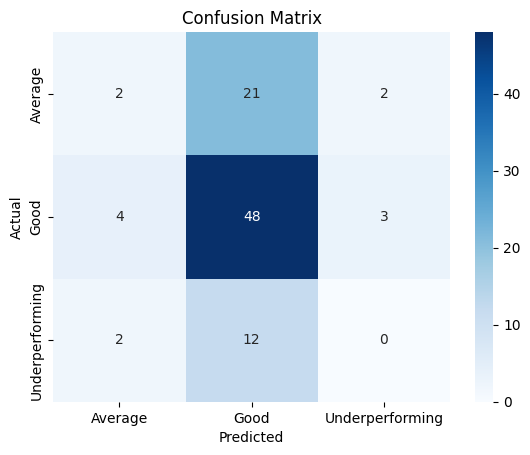

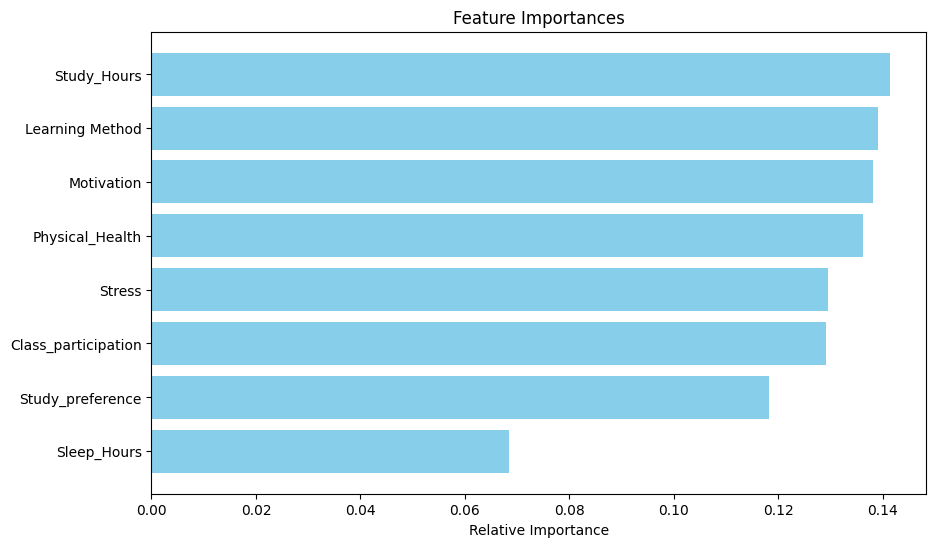


Enter student's details:
Error encoding 'Learning Method': y contains previously unseen labels: ''. Please enter a valid category.
Error encoding 'Study_preference': y contains previously unseen labels: ''. Please enter a valid category.
Error encoding 'Class_participation': y contains previously unseen labels: ''. Please enter a valid category.

Predicted Performance Category: Good


: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Load your Excel file
data = pd.read_excel('raw data-2.xlsx')

# Step 2: Define categories based on last semester marks
def categorize_marks(marks):
    if marks >= 75:
        return 'Good'
    elif marks >= 55:
        return 'Average'
    else:
        return 'Underperforming'

data['Performance'] = data['Marks'].apply(categorize_marks)

# Step 3: Prepare features and labels
features = ['Study_Hours', 'Sleep_Hours', 'Stress', 'Motivation',
            'Class_participation', 'Learning Method', 'Study_preference', 'Physical_Health']
X = data[features]
y = data['Performance']

# Step 4: Encode categorical columns
categorical_cols = ['Learning Method', 'Study_preference', 'Class_participation']

label_encoders = {}  # Dictionary to store fitted LabelEncoder objects
X_encoded = X.copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le  # Store the fitted encoder

# Step 5: Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 6: Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 7: Predictions
y_pred = model.predict(X_test)

# Step 8: Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 9: Feature Importance Plot
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


# === Take user input and predict ===

print("\nEnter student's details:")
user_input_dict = {}
for feature in features:
    value = input(f"{feature}: ")
    user_input_dict[feature] = value

# Create a DataFrame from the user input
user_df = pd.DataFrame([user_input_dict])

# Encode categorical columns using the *fitted* encoders
user_df_encoded = user_df.copy()
for col in categorical_cols:
    try:
        user_df_encoded[col] = label_encoders[col].transform(user_df_encoded[col])
    except KeyError:
        print(f"Warning: Category '{user_df[col].iloc[0]}' for '{col}' not seen during training. Prediction might be unreliable.")
    except ValueError as e:
        print(f"Error encoding '{col}': {e}. Please enter a valid category.")
        exit() # Or handle the error appropriately

# Convert all to numeric, with error handling
for col in user_df_encoded.columns:
    try:
        user_df_encoded[col] = pd.to_numeric(user_df_encoded[col])
    except ValueError:
        print(f"Error: Please enter a numeric value for '{col}'.")
        exit() # Or handle the error appropriately

# Ensure the user input DataFrame has the same columns and order as the training data
user_df_encoded = user_df_encoded[X_train.columns]

# Predict
prediction = model.predict(user_df_encoded)[0]
print(f"\nPredicted Performance Category: {prediction}")

observation on habit model :
classification solely based on marks isn't reliable. this is causing biasness to good performance. This is caused due to error in data.

We yet have to rectify this bias.

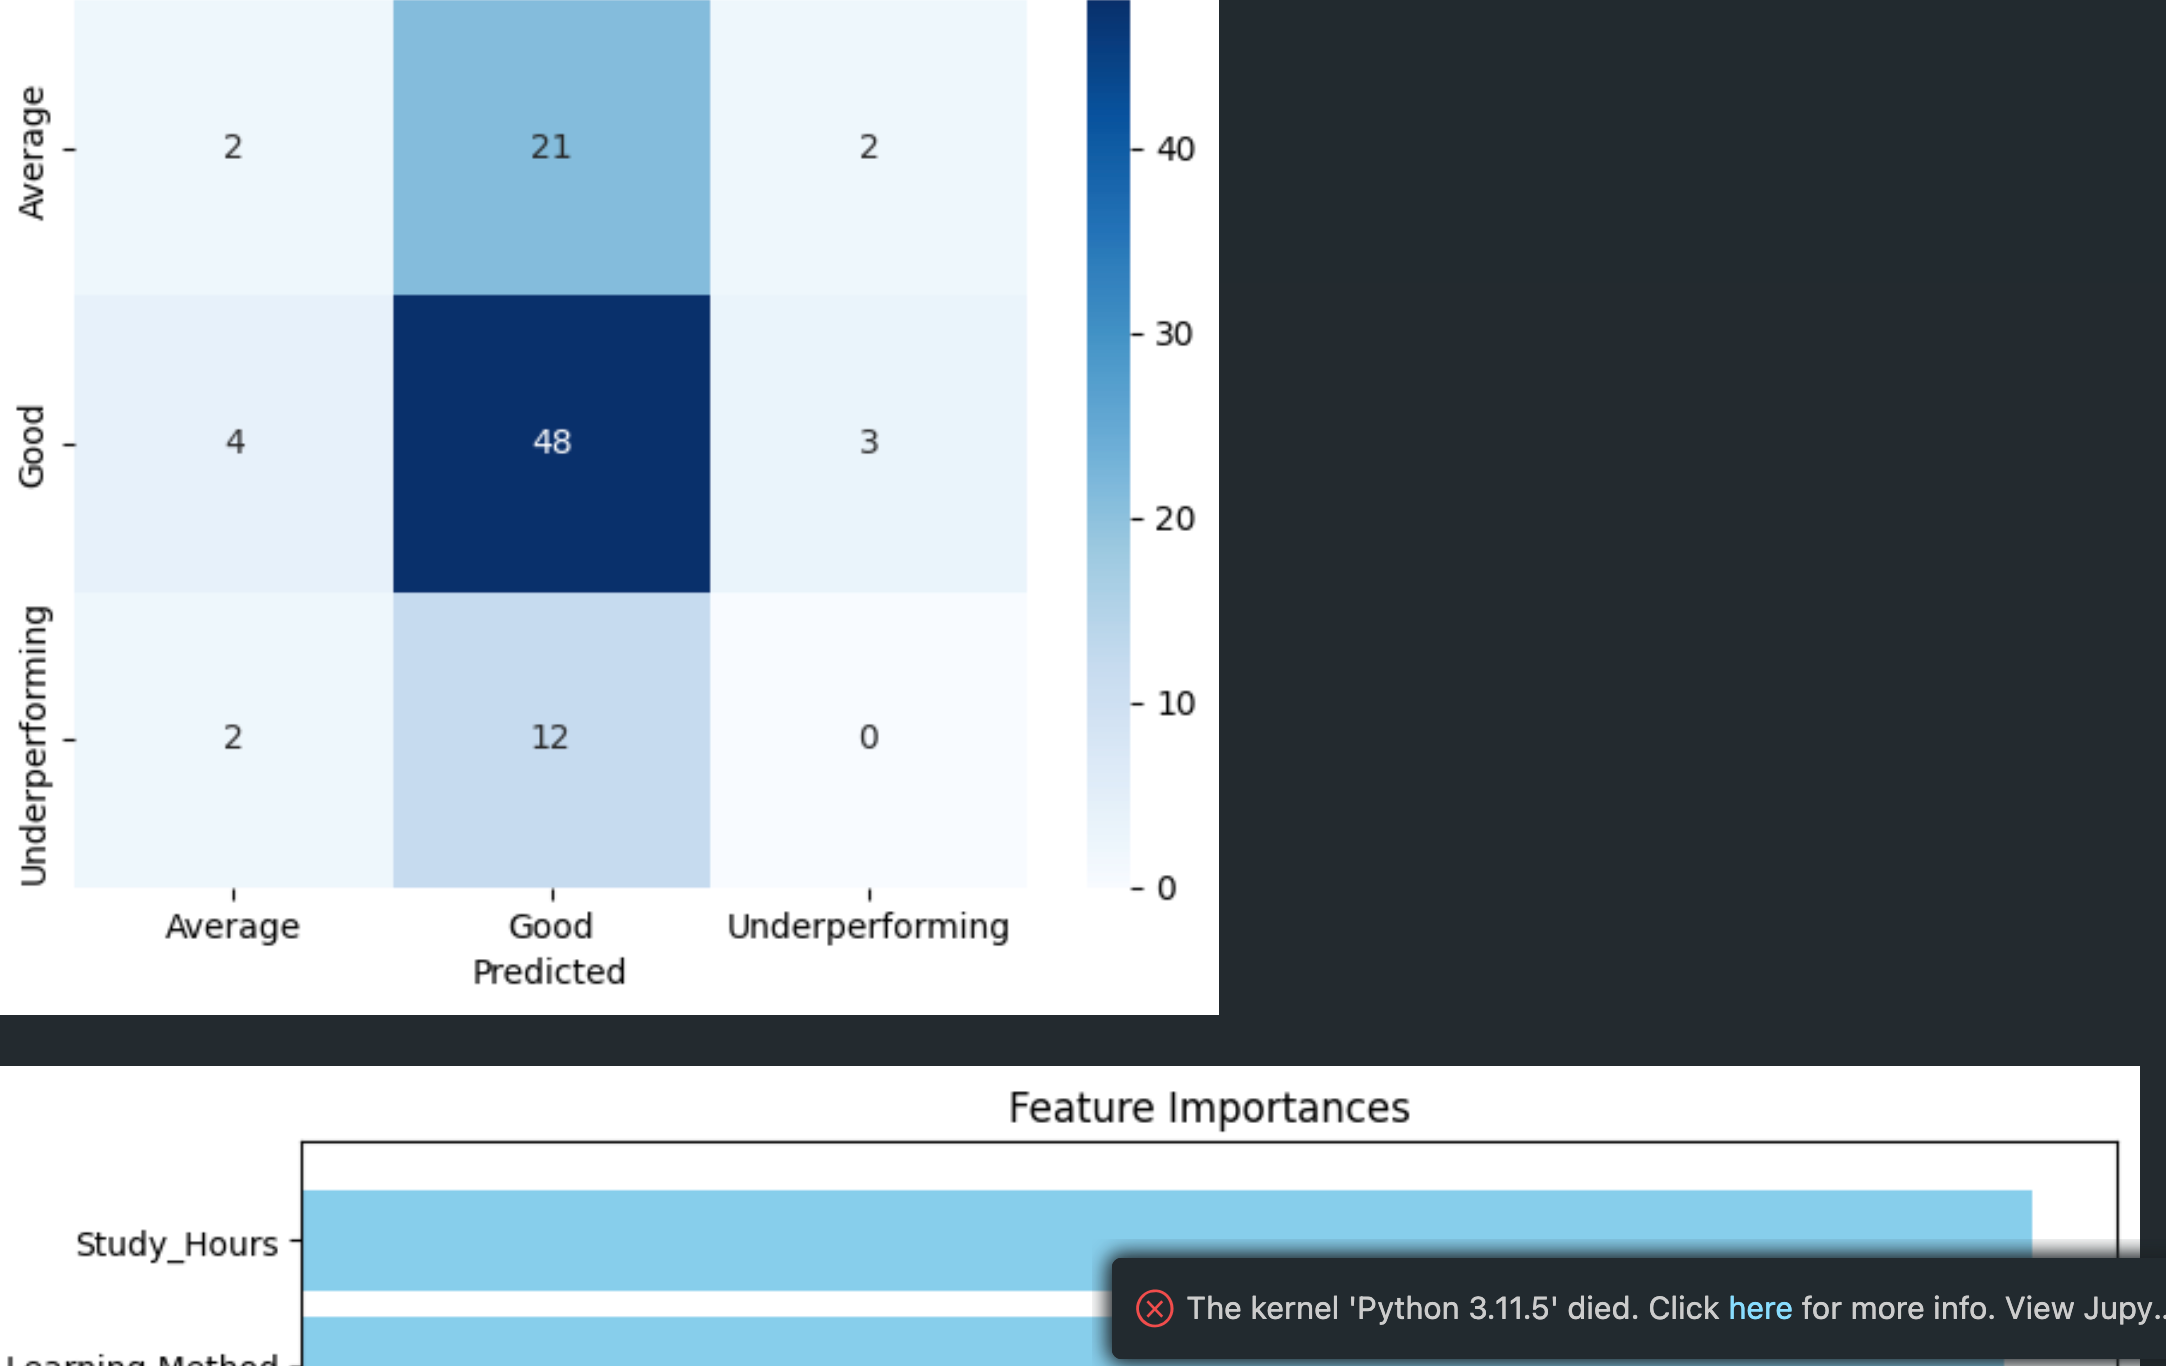